# TP 1 : FC & CNN

**Il est interdit d'utiliser la fonction 'compile' de TensorFlow pour ce TP**

Veillez à commenter votre code, vous pouvez aussi ajouter des cellules de markdown dans lesquelles vous expliquez vos raisonnements et les raisons de vos choix.
Ces commentaires seront pris en compte pour l'évaluation du travail.

Le but de ce TP sera de vous familiariser avec l'utilisation de TensorFlow et Keras pour la création et l'entraînement de modèles fully-connected puis à convolutions simples.
Vous entraînerez des modèles sur une tâche de classification sur les jeux de données MNIST.
Ces jeux de données sont composés d'images de dimensions 28x28 et ont l'avantage d'être très simples d'utilisation ainsi que de permettre un apprentissage rapide.

Nous allons utiliser la librairie TensorFlow et faire tourner notre code sous Google Colab pour nos TP, ce qui aura l'avantage de nous permettre d'utiliser les GPUs mis à disposition gratuitement par Google.
Vous êtes libre d'utiliser une autre librairie que TensorFlow si vous en maîtrisez une autre ou votre machine personnelle si celle-ci possède un GPU suffisant, mais il est probable que les phases d'entraînement soit plus rapides sous Colab.

N'hésitez pas à vous référer aux docs de TensorFlow 2 et Keras disponibles sur internet lors de ce TP.

Ce TP s'effectue individuellement ou en binome.
Veuillez respecter les consignes suivantes pour le rendu de votre travail :

*   Renommez le selon le format suivant : "DL_2023_TP_CNN_prenom1_nom1_prenom2_nom2.ipynb".
*   Veillez à ce que vos noms et prénoms soient complétés dans la cellule ci-dessous.
*   Veillez à avoir bien exécuté toutes les cellules de code et que les résultats soient tous bien visible dans le notebook sans nécessiter une ré-exécution.
*   Partagez le notebook avec ranvier.thomas.pro@gmail.com.

Si vous avez effectué le TP autrement que sur Google Colab :

*   Renommez le selon le format suivant : "DL_2023_TP_CNN_prenom1_nom1_prenom2_nom2.ipynb".
*   Téléchargez le fichier ipynb.
*   Envoyez le fichier en pièce-jointe à ranvier.thomas.pro@gmail.com, en indiquant en tant qu'objet : "TP CNN prenom1 nom1 prenom2 nom2".
---

## Veuillez compléter vos noms et prénoms ci-dessous :

*   **Prenom 1** : Aicha
*   **Nom 1** : EL BOU

In [ ]:
import tensorflow as tf

# Si vous obtenez une erreur à ce niveau veuillez suivre ces indications :
# "Modifier" > "Paramètres du notebook" > "Accélérateur matériel" > "GPU"

device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
    raise SystemError('GPU device not found')
print(f'Found GPU: {device_name}')

Found GPU: /device:GPU:0


In [ ]:
import matplotlib.pyplot as plt

%matplotlib inline

---
# Preparation des données MNIST

Vous allez utiliser le jeu de données MNIST qui contient des chiffres ayant été écrit à la main, le but va être de créer des réseaux de neurones qui vont apprendre à reconnaître et correctement classifier ces chiffres.

In [ ]:
# Load data
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()

11490434/11490434 [==============================] - 0s 0us/step


Il est important de toujours normaliser les données entre 0 et 1 pour qu'un réseau de neurones soit capable de les traiter convenablement.

Normalisez les données entre 0 et 1

- La normalisation des données est effectuée en divisant chaque pixel des images par 255.
- Cette opération ramène les valeurs des pixels à une plage entre 0 et 1. Cela est important pour que le modèle de réseau de neurones traite les données de manière efficace, car cela peut aider à éviter les problèmes liés à l'échelle des caractéristiques.

In [ ]:
# Normalize data
x_train = x_train/255.0
x_test = x_test/255.0


Ajoutez une dimension vide supplémentaire aux données, elle correspond à la dimension des channels nécessaire pour les opérations de convolutions.

Par exemple, les dimensions de x_train sont (60000, 28, 28), elles doivent devenir (60000, 28, 28, 1)

- Les données initiales ont une forme de (nombre_d'échantillons, largeur, hauteur).
- En ajoutant une dimension supplémentaire à la fin (pour les channels), les données auront maintenant la forme (nombre_d'échantillons, largeur, hauteur, 1).
- Cette étape est nécessaire pour les opérations de convolution dans les modèles CNN (Convolutional Neural Networks), car elles attendent des données avec une dimension de channel.

In [ ]:
# Add channel dimension
x_train = x_train.reshape(x_train.shape[0],x_train.shape[1],x_train.shape[2],1)
x_test = x_test.reshape(x_test.shape[0],x_test.shape[1],x_test.shape[2],1)

print("x_train new shape : " ,x_train.shape)
print("x_test new shape : " ,x_test.shape)

x_train new shape :  (60000, 28, 28, 1)
x_test new shape :  (10000, 28, 28, 1)


Séparez le jeu de données d'entraînement en un jeu de validation de taille 10000 et un nouveau jeu d'entraînement de taille 50000.

- Cette séparation est utilisée pour évaluer la performance du modèle sur un ensemble de validation indépendant pendant l'entraînement.

In [ ]:
# Split train val
x_val, y_val = x_train[:10000], y_train[:10000]
x_train, y_train = x_train[10000:], y_train[10000:]

print("x_val new shape : " ,x_val.shape)
print("x_train new shape : " ,x_train.shape)

x_val new shape :  (10000, 28, 28, 1)
x_train new shape :  (50000, 28, 28, 1)


Si les traîtements effectués ci-dessus sur les données sont corrects l'execution de la cellule de code suivante devrait vous afficher les 25 premières images d'entraînement associées à leurs labels.

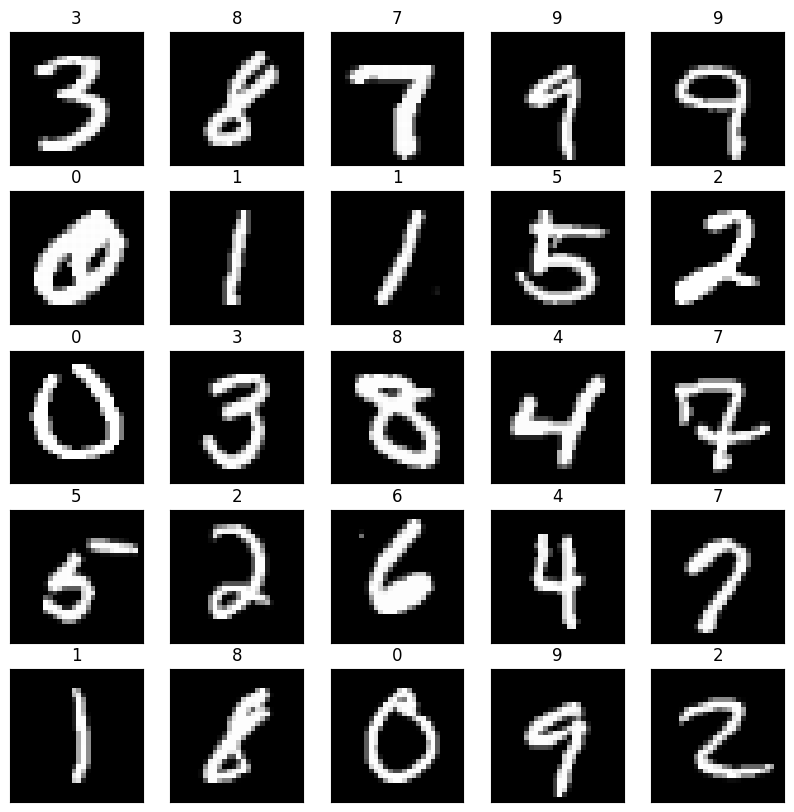

In [ ]:
# Plot grid with first 25 training images with their corresponding label
plt.figure(figsize=(10, 10))
for i in range(25):
    plt.subplot(5, 5, i+1)
    plt.xticks([])
    plt.yticks([])
    plt.imshow(x_train[i].squeeze(), cmap='gray')
    plt.title(y_train[i])
plt.show()

---
# Entraîner un modèle fully-connected sur les données MNIST

Il faut maintenant définir un modèle fully-connected, l'entrainer sur le jeu d'entraînement et évaluer ses performances en terme d'accuracy (https://keras.io/api/metrics/accuracy_metrics/) sur le jeu de test.
Il faudra chercher la meilleure architecture et les meilleurs paramètres possibles de manière empirique en testant différentes valeurs pour chaque.
Avec de bons paramètres vous devriez pouvoir atteindre une accuracy d'au minimum 96% sur le jeu de test.
Reportez vous à la documentation Keras https://keras.io/api/ pour prendre connaissance des différentes fonctionnalités utilisables ainsi que les paramètres qu'il est possible de modifier pour chaque.

Objectifs principaux :
- Définir une architecture et des hyper-paramètres adaptés
- Obtenir 96% d'accuracy sur le jeu de test

Objectifs secondaires :
- Entraînement en mini-batches
- Suivi de l'évolution de la loss et de l'accuracy sur le jeu d'entrainement sur un graph
- Suivi de l'évolution de la loss et de l'accuracy sur le jeu de validation sur un graph

Epoch 1/10, Train Loss: 0.40901514887809753, Train Accuracy: 0.7635470628738403, Validation Loss: 0.22082065045833588, Validation Accuracy: 0.8877666592597961
Epoch 2/10, Train Loss: 0.1701229363679886, Train Accuracy: 0.9036487340927124, Validation Loss: 0.15794792771339417, Validation Accuracy: 0.9190000295639038
Epoch 3/10, Train Loss: 0.12365515530109406, Train Accuracy: 0.9259716868400574, Validation Loss: 0.12275014817714691, Validation Accuracy: 0.9337388873100281
Epoch 4/10, Train Loss: 0.09703165292739868, Train Accuracy: 0.937968909740448, Validation Loss: 0.11317026615142822, Validation Accuracy: 0.9427708387374878
Epoch 5/10, Train Loss: 0.0796947330236435, Train Accuracy: 0.9457583427429199, Validation Loss: 0.11037696897983551, Validation Accuracy: 0.949126660823822
Epoch 6/10, Train Loss: 0.06498679518699646, Train Accuracy: 0.9514549374580383, Validation Loss: 0.11310194432735443, Validation Accuracy: 0.9540389180183411
Epoch 7/10, Train Loss: 0.05410554260015488, Train

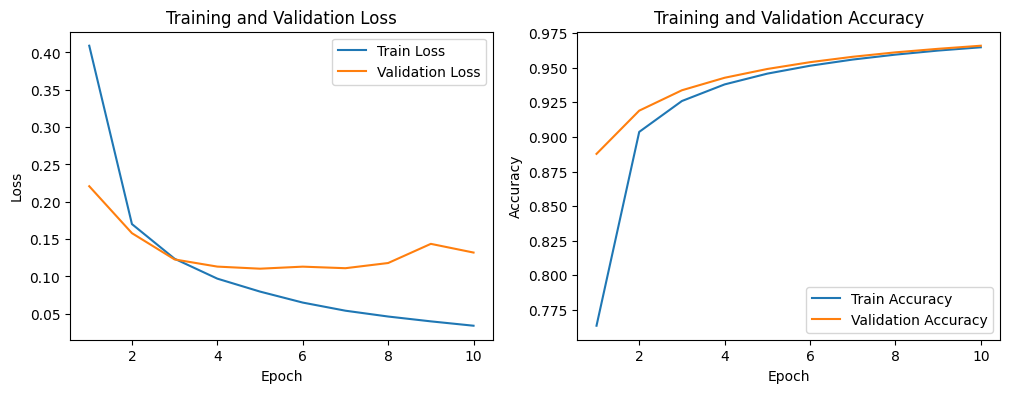

Test Accuracy: 96.60%


In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Define model
model = tf.keras.Sequential([
    tf.keras.layers.Flatten(input_shape=(28, 28, 1)),
    tf.keras.layers.Dense(units=64, activation='relu'),
    tf.keras.layers.Dense(units=32, activation='relu'),
    tf.keras.layers.Dense(units=16, activation='relu'),
    tf.keras.layers.Dense(units=10, activation='softmax')
])

# Set hyperparameters
loss_function = tf.keras.losses.SparseCategoricalCrossentropy()
optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)
epochs = 10
batch_size = 64
metric = tf.keras.metrics.SparseCategoricalAccuracy()

# Training here
train_loss_values = []
train_accuracy_values = []
val_loss_values = []
val_accuracy_values = []

for epoch in range(epochs):
    epoch_train_losses = []
    epoch_train_accuracies = []

    for i in range(0, len(x_train), batch_size):
        x_batch = x_train[i:i + batch_size]
        y_batch = y_train[i:i + batch_size]

        with tf.GradientTape() as tape:
            predictions = model(x_batch)
            loss = loss_function(y_batch, predictions)

        gradients = tape.gradient(loss, model.trainable_variables)
        optimizer.apply_gradients(zip(gradients, model.trainable_variables))
        batch_accuracy = metric(y_batch, predictions)
        epoch_train_accuracies.append(batch_accuracy)
        epoch_train_losses.append(loss)

    train_loss = np.mean(epoch_train_losses)
    train_accuracy = np.mean(epoch_train_accuracies)
    train_loss_values.append(train_loss)
    train_accuracy_values.append(train_accuracy)
    val_predictions = model(x_val)
    val_loss = loss_function(y_val, val_predictions)
    val_accuracy = metric(y_val, val_predictions)
    val_loss_values.append(val_loss)
    val_accuracy_values.append(val_accuracy)

    print(f"Epoch {epoch + 1}/{epochs}, Train Loss: {train_loss}, Train Accuracy: {train_accuracy}, "
          f"Validation Loss: {val_loss}, Validation Accuracy: {val_accuracy}")

# les graphiques d'évolution de la loss et de l'accuracy
epochs_range = range(1, epochs + 1)

plt.figure(figsize=(12, 4))

#Graphique de la loss
plt.subplot(1, 2, 1)
plt.plot(epochs_range, train_loss_values, label='Train Loss')
plt.plot(epochs_range, val_loss_values, label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# Graphique de l'accuracy
plt.subplot(1, 2, 2)
plt.plot(epochs_range, train_accuracy_values, label='Train Accuracy')
plt.plot(epochs_range, val_accuracy_values, label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

#Évaluation du modèle sur le jeu de test
test_predictions = model(x_test)
test_accuracy = metric(y_test, test_predictions)
print(f"Test Accuracy: {test_accuracy.numpy() * 100:.2f}%")


---
# Entraîner un modèle à convolutions sur les données MNIST

Il faut maintenant définir un modèles à convolutions, l'entrainer sur le jeu d'entraînement et évaluer ses performances sur le jeu de test.
Il faudra chercher la meilleure architecture et les meilleurs paramètres possibles de manière empirique en testant différentes valeurs pour chaque.
Avec de bons paramètres vous devriez pouvoir atteindre une accuracy d'au minimum 98% sur le jeu de test.

Objectifs principaux :
- Définir une architecture et des hyper-paramètres adaptés
- Obtenir 98% d'accuracy sur le jeu de test

Objectifs secondaires :
- Entraînement en mini-batches
- Suivi de l'évolution de la loss et de l'accuracy sur le jeu d'entrainement sur un graph
- Suivi de l'évolution de la loss et de l'accuracy sur le jeu de validation sur un graph
- Utilisation de batch-normalizations
- Utilisation d'un dropout

Epoch 1/10, Train Loss: 0.17009350657463074, Train Accuracy: 0.8812167048454285, Validation Loss: 0.0990506112575531, Validation Accuracy: 0.9506833553314209
Epoch 2/10, Train Loss: 0.04939141124486923, Train Accuracy: 0.9594685435295105, Validation Loss: 0.053067345172166824, Validation Accuracy: 0.9675750136375427
Epoch 3/10, Train Loss: 0.030299510806798935, Train Accuracy: 0.9714779257774353, Validation Loss: 0.047989826649427414, Validation Accuracy: 0.9751944541931152
Epoch 4/10, Train Loss: 0.021819908171892166, Train Accuracy: 0.9773927330970764, Validation Loss: 0.0430050790309906, Validation Accuracy: 0.9795250296592712
Epoch 5/10, Train Loss: 0.016428561881184578, Train Accuracy: 0.9809628129005432, Validation Loss: 0.07101520895957947, Validation Accuracy: 0.982200026512146
Epoch 6/10, Train Loss: 0.01354438066482544, Train Accuracy: 0.9832262396812439, Validation Loss: 0.04666072875261307, Validation Accuracy: 0.9842472076416016
Epoch 7/10, Train Loss: 0.011286196298897266

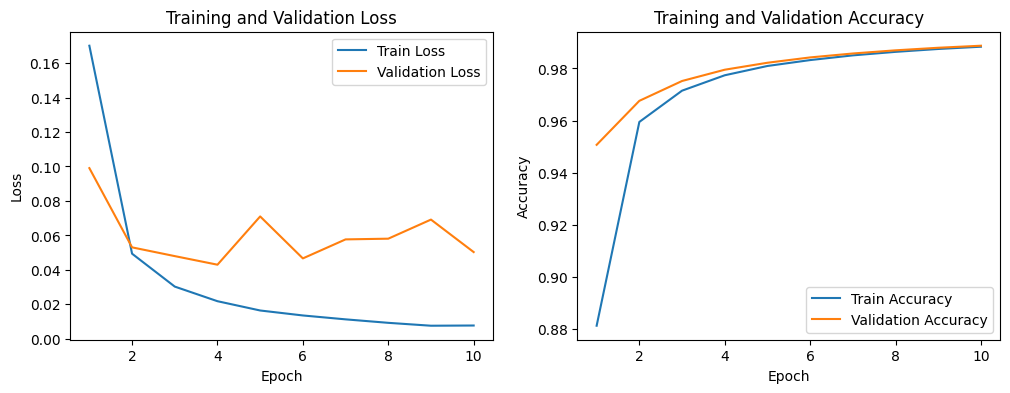

Test Accuracy: 98.88%


In [ ]:
# Define model
model = tf.keras.Sequential([
    tf.keras.layers.Conv2D(32, 5, strides=1, padding='same', activation='relu', input_shape=(28, 28, 1)),
    tf.keras.layers.MaxPool2D(pool_size=(2, 2)),
    tf.keras.layers.Conv2D(64, 3, strides=1, padding='same', activation='relu'),
    tf.keras.layers.MaxPool2D(pool_size=(2, 2)),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(units=128, activation='relu'),
    tf.keras.layers.Dropout(0.5),  # Ajout d'une couche de dropout
    tf.keras.layers.Dense(units=10, activation='softmax')  # Correction ici : utiliser units=10
])

# Set hyperparameters
loss_function = tf.keras.losses.SparseCategoricalCrossentropy()
optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)
epochs = 10
batch_size = 64
metric = tf.keras.metrics.SparseCategoricalAccuracy()

# Training here
train_loss_values = []
train_accuracy_values = []
val_loss_values = []
val_accuracy_values = []

#entraînement du modèle avec mini-batches et suivi de l'évolution
for epoch in range(epochs):
    epoch_train_losses = []
    epoch_train_accuracies = []

    for i in range(0, len(x_train), batch_size):
        x_batch = x_train[i:i + batch_size]
        y_batch = y_train[i:i + batch_size]
        with tf.GradientTape() as tape:
            predictions = model(x_batch)
            loss = loss_function(y_batch, predictions)

        gradients = tape.gradient(loss, model.trainable_variables)
        optimizer.apply_gradients(zip(gradients, model.trainable_variables))
        batch_accuracy = metric(y_batch, predictions)
        epoch_train_accuracies.append(batch_accuracy)
        epoch_train_losses.append(loss)

    train_loss = np.mean(epoch_train_losses)
    train_accuracy = np.mean(epoch_train_accuracies)
    train_loss_values.append(train_loss)
    train_accuracy_values.append(train_accuracy)
    val_predictions = model(x_val)
    val_loss = loss_function(y_val, val_predictions)
    val_accuracy = metric(y_val, val_predictions)
    val_loss_values.append(val_loss)
    val_accuracy_values.append(val_accuracy)

    print(f"Epoch {epoch + 1}/{epochs}, Train Loss: {train_loss}, Train Accuracy: {train_accuracy}, "
          f"Validation Loss: {val_loss}, Validation Accuracy: {val_accuracy}")

epochs_range = range(1, epochs + 1)
plt.figure(figsize=(12, 4))

# Graphique de la loss
plt.subplot(1, 2, 1)
plt.plot(epochs_range, train_loss_values, label='Train Loss')
plt.plot(epochs_range, val_loss_values, label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

#graphique de l'accuracy
plt.subplot(1, 2, 2)
plt.plot(epochs_range, train_accuracy_values, label='Train Accuracy')
plt.plot(epochs_range, val_accuracy_values, label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

test_predictions = model(x_test)
test_accuracy = metric(y_test, test_predictions)
print(f"Test Accuracy: {test_accuracy.numpy() * 100:.2f}%")

---
# Préparation des données Fashion MNIST

Vous allez utiliser le jeu de données Fashion MNIST qui contient des images de vétements, le but va être de définir un CNN qui va apprendre à reconnaître et correctement classifier les images.

Objectifs principaux :
- Définir une architecture et des hyper-paramètres adaptés
- Obtenir 90% d'accuracy sur le jeu de test

Objectifs secondaires :
- Entraînement en mini-batches
- Suivi de l'évolution de la loss et de l'accuracy sur le jeu d'entrainement sur un graph
- Suivi de l'évolution de la loss et de l'accuracy sur le jeu de validation sur un graph
- Utilisation de batch-normalizations
- Utilisation d'un dropout
- Rendre générique la phase d'entrainement du modèle afin de limiter les copier-collers des parties précédentes

In [ ]:
# Load data
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.fashion_mnist.load_data()
class_names = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
               'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']

# Normalize data
x_train = x_train / 255.0
x_test = x_test / 255.0

# Add channel dimension
x_train = x_train.reshape(x_train.shape[0], x_train.shape[1], x_train.shape[2], 1)
x_test = x_test.reshape(x_test.shape[0], x_test.shape[1], x_test.shape[2], 1)

# Split train val
x_val, y_val = x_train[:10000], y_train[:10000]
x_train, y_train = x_train[10000:], y_train[10000:]



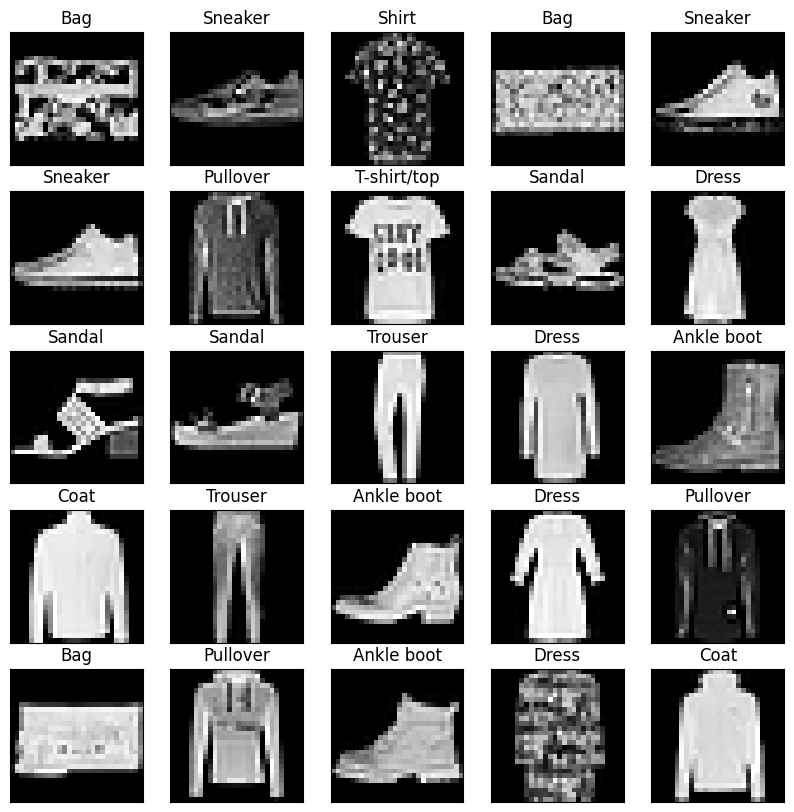

In [ ]:
# Plot grid with first 25 training images with their corresponding label
plt.figure(figsize=(10,10))
for i in range(25):
    plt.subplot(5, 5, i+1)
    plt.xticks([])
    plt.yticks([])
    plt.imshow(x_train[i].squeeze(), cmap='gray')
    plt.title(class_names[y_train[i]])
plt.show()

Epoch 1/10, Train Loss: 0.45207110047340393, Train Accuracy: 0.7714175581932068, Validation Loss: 0.33929017186164856, Validation Accuracy: 0.8431333303451538
Epoch 2/10, Train Loss: 0.28977060317993164, Train Accuracy: 0.855950653553009, Validation Loss: 0.30764180421829224, Validation Accuracy: 0.8673499822616577
Epoch 3/10, Train Loss: 0.24297557771205902, Train Accuracy: 0.874138355255127, Validation Loss: 0.2845628559589386, Validation Accuracy: 0.8807166814804077
Epoch 4/10, Train Loss: 0.20930498838424683, Train Accuracy: 0.8854896426200867, Validation Loss: 0.2788541913032532, Validation Accuracy: 0.8901041746139526
Epoch 5/10, Train Loss: 0.17991404235363007, Train Accuracy: 0.8939343094825745, Validation Loss: 0.27853924036026, Validation Accuracy: 0.8976200222969055
Epoch 6/10, Train Loss: 0.15254561603069305, Train Accuracy: 0.9009920954704285, Validation Loss: 0.32161688804626465, Validation Accuracy: 0.9039333462715149
Epoch 7/10, Train Loss: 0.12787646055221558, Train Ac

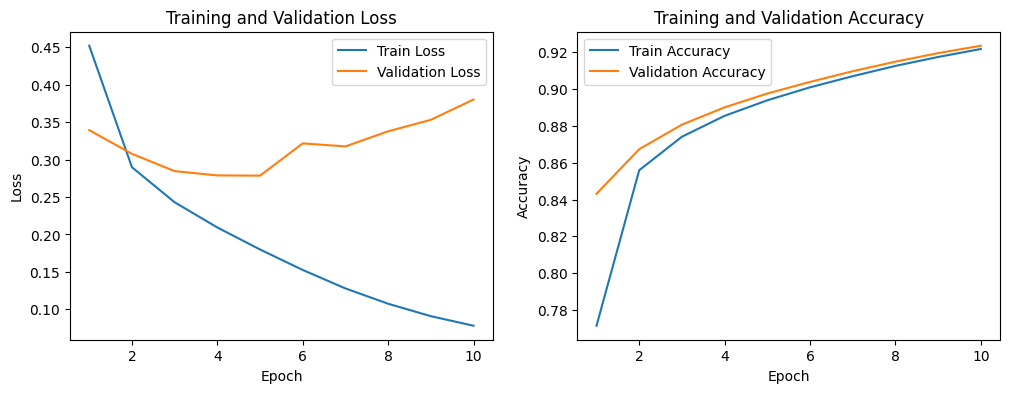

Test Accuracy: 92.32%


In [ ]:
# Define model
model = tf.keras.Sequential([
    tf.keras.layers.Conv2D(32, 5, strides=1, padding='same', activation='relu', input_shape=(28, 28, 1)),
    tf.keras.layers.MaxPool2D(pool_size=(2, 2)),
    tf.keras.layers.Conv2D(64, 3, strides=1, padding='same', activation='relu'),
    tf.keras.layers.MaxPool2D(pool_size=(2, 2)),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(units=128, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(units=10, activation='softmax')
])

# Set hyperparameters
loss_function = tf.keras.losses.SparseCategoricalCrossentropy()
optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)
epochs = 10
batch_size = 64
metric = tf.keras.metrics.SparseCategoricalAccuracy()

# Training here
def train_model(model, x_train, y_train, x_val, y_val, epochs, batch_size):
    train_loss_values = []
    train_accuracy_values = []
    val_loss_values = []
    val_accuracy_values = []

    for epoch in range(epochs):
        epoch_train_losses = []
        epoch_train_accuracies = []

        for i in range(0, len(x_train), batch_size):
            x_batch = x_train[i:i + batch_size]
            y_batch = y_train[i:i + batch_size]

            with tf.GradientTape() as tape:
                predictions = model(x_batch)
                loss = loss_function(y_batch, predictions)

            gradients = tape.gradient(loss, model.trainable_variables)
            optimizer.apply_gradients(zip(gradients, model.trainable_variables))

            batch_accuracy = metric(y_batch, predictions)
            epoch_train_accuracies.append(batch_accuracy)
            epoch_train_losses.append(loss)

        train_loss = np.mean(epoch_train_losses)
        train_accuracy = np.mean(epoch_train_accuracies)
        train_loss_values.append(train_loss)
        train_accuracy_values.append(train_accuracy)

        val_predictions = model(x_val)
        val_loss = loss_function(y_val, val_predictions)
        val_accuracy = metric(y_val, val_predictions)
        val_loss_values.append(val_loss)
        val_accuracy_values.append(val_accuracy)

        print(f"Epoch {epoch + 1}/{epochs}, Train Loss: {train_loss}, Train Accuracy: {train_accuracy}, "
              f"Validation Loss: {val_loss}, Validation Accuracy: {val_accuracy}")

    return train_loss_values, train_accuracy_values, val_loss_values, val_accuracy_values


train_loss_values, train_accuracy_values, val_loss_values, val_accuracy_values = train_model(
    model, x_train, y_train, x_val, y_val, epochs, batch_size
)

epochs_range = range(1, epochs + 1)

plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(epochs_range, train_loss_values, label='Train Loss')
plt.plot(epochs_range, val_loss_values, label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(epochs_range, train_accuracy_values, label='Train Accuracy')
plt.plot(epochs_range, val_accuracy_values, label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

# Evaluate the model on the test set
test_predictions = model(x_test)
test_accuracy = metric(y_test, test_predictions)
print(f"Test Accuracy: {test_accuracy.numpy() * 100:.2f}%")


Si l'apprentissage ci-dessus s'est bien passé l'executions des 2 cellules de code suivantes devraient vous afficher respectivement les 25 premières images de test avec le label prédit et le label réel pour chaque et les 40 premières images de test avec les probabilités émisent par le modèle pour chacune des classes.

La variable 'predictions' doit contenir les prédictions obtenus sur le jeu de test.

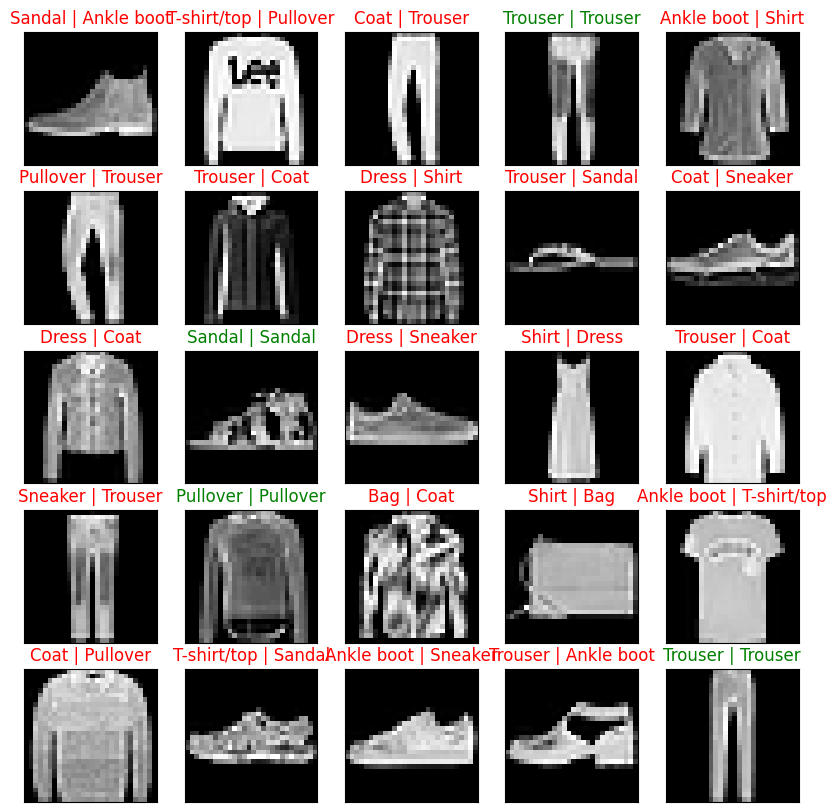

In [ ]:
# Plot grid with first 25 test images with their predicted and true label
plt.figure(figsize=(10,10))
for i in range(25):
    plt.subplot(5, 5, i+1)
    plt.xticks([])
    plt.yticks([])
    plt.imshow(x_test[i].squeeze(), cmap='gray')
    pred = val_predictions[i].numpy().argmax()
    true = y_test[i]
    color = 'green' if pred == true else 'red'
    plt.title(f'{class_names[pred]} | {class_names[true]}', color=color)
plt.show()

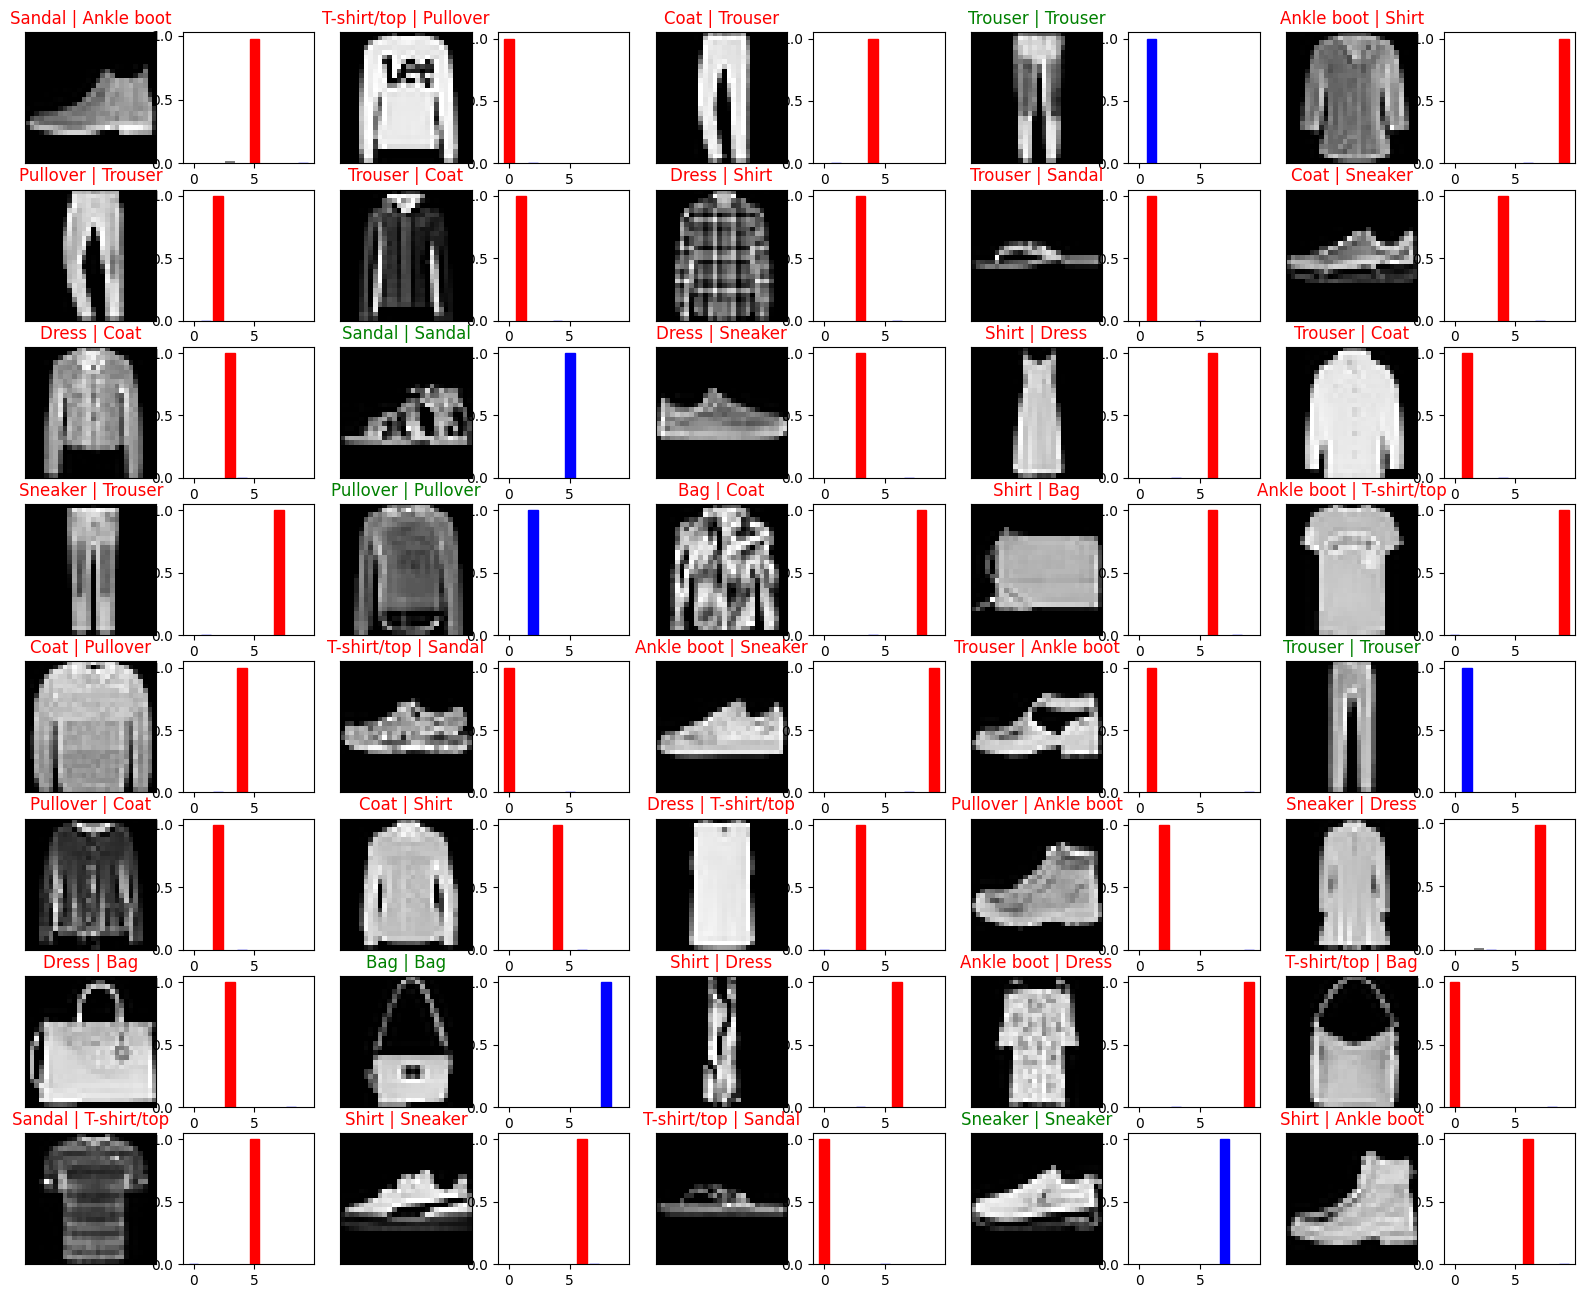

In [ ]:
# Plot grid with first 40 test images with the model probabilities
plt.figure(figsize=(20, 16))
for i in range(40):
    plt.subplot(8, 10, (i*2)+1)
    plt.xticks([])
    plt.yticks([])
    plt.imshow(x_test[i].squeeze(), cmap='gray')
    pred = val_predictions[i].numpy().argmax()
    true = y_test[i]
    color = 'green' if pred == true else 'red'
    plt.title(f'{class_names[pred]} | {class_names[true]}', color=color)
    plt.subplot(8, 10, (i*2)+2)
    barplt = plt.bar(list(range(len(class_names))), val_predictions[i].numpy(),
                     color='gray')
    barplt[pred].set_color('red')
    barplt[true].set_color('blue')
plt.show()